# Vision Transformers (ViT)

## Overview

In this tutorial, we explore the growing trend of using Transformers in Computer Vision. Inspired by the work of Alexey Dosovitskiy et al., who demonstrated the effectiveness of Transformers for image recognition, researchers have increasingly investigated whether convolutional neural networks (CNNs) should remain the default architecture for vision tasks.

How do Vision Transformers (ViTs) work? How do they compare to CNNs in terms of performance, advantages, and limitations? To answer these questions, we will implement a Vision Transformer (ViT) from scratch and train it on the widely used CIFAR-10 dataset—just as we previously did for CNNs.

## Learning Objectives
By the end of this tutorial, you will be able to:
- Understand how Vision Transformers (ViTs) work.
- Implement a ViT model using PyTorch.
- Compare ViTs with CNNs in terms of performance.

In [1]:
# Uncomment to install the necessary libraries for this notebook.
%pip install numpy torch torchvision matplotlib

#  Let's import the necessary libraries for this notebook.
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import CIFAR10

%matplotlib inline

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## 0. Loading the Dataset

Below, we load the CIFAR-10 dataset. To ensure a fair comparison, we use the same data augmentation setup as in the CNN notebook.

100%|██████████| 170M/170M [01:28<00:00, 1.93MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


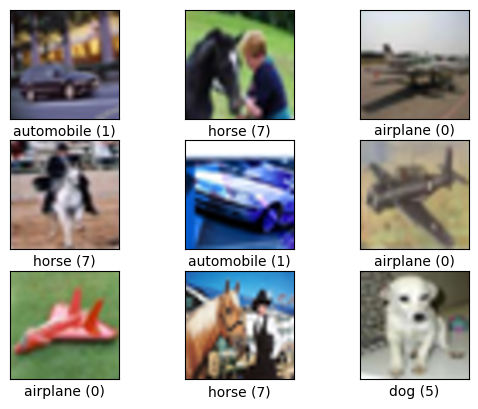

In [4]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # define transforms for training, including augmentation if specified
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    val_set = torch.utils.data.Subset(valid_dataset, valid_idx)

    return (train_loader, valid_loader, val_set)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

train_loader, val_loader, val_set = get_train_valid_loader(augment=False)
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)

## Introduction:
### Using transformers for image classification

Transformers were originally introduced to handle sets because they are permutation-equivariant, meaning that if the input is permuted, the output will be permuted in the same way. To adapt Transformers for sequential data, a positional encoding was added to the input vectors, enabling the model to learn how to use it on its own. The same idea naturally extends to images, as demonstrated by Alexey Dosovitskiy et al. in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." In this work, the Vision Transformer treats an image as a sequence of smaller patches. For example, a $48 \times 48$ image can be split into nine $16 \times 16$ patches, each acting as a “token” that is projected into a feature space. By incorporating positional encodings and adding a classification token, the standard Transformer architecture can then be applied to this sequence for image classification.

Here is an image of the ViT transformer performing for classification:

<div align="center">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" alt="Vision Transformer">
</div>

### Transformer Block

The Transformer block is a fundamental component of the Vision Transformer (ViT) architecture. It consists of multiple layers of multi-head self-attention and feedforward neural networks, which enable the model to capture complex dependencies and relationships within the input data.

Below is a visual representation of the Transformer encoder structure:

<div align="center">
  <img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" alt="Transformer block">
</div>

In this structure, the input data is first processed by a multi-head self-attention mechanism, which allows the model to focus on different parts of the input simultaneously. This is followed by a feedforward neural network that further processes the data. Both the attention and feedforward layers are equipped with residual connections and layer normalization to stabilize training and improve performance.

The Transformer block is highly versatile and can be stacked multiple times to build deep models capable of handling complex tasks such as image classification, natural language processing, and more.

#### Let's dive into the coding now!!!

Complete the sections marked with TODO and ???. The provided comments will guide you through the process and help you understand the workflow.

If you have any questions or need clarification, don't hesitate to ask the TAs for assistance.

## 1. Image to Patch

First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer.

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Splits an image into patches.

    Parameters:
        x (torch.Tensor): Image tensor of shape [B, C, H, W].
        patch_size (int): Size of each patch (patches are patch_size x patch_size).
        flatten_channels (bool): If True, each patch is flattened into a vector.

    Returns:
        torch.Tensor: A tensor of patches.
            - If flatten_channels is True, the output shape is [B, num_patches, C * patch_size * patch_size].
            - If False, the output shape is [B, num_patches, C, patch_size, patch_size],
            where num_patches = (H / patch_size) * (W / patch_size).
    """
    B, C, H, W = x.shape
    # TODO : Implement the split into patches
    # Output shape should be [B, num_patches, C * patch_size * patch_size]
    num_patches = (H // patch_size) * (W // patch_size)
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)

    if flatten_channels:
        x = x.reshape(B, num_patches, C * patch_size * patch_size)
    else:
        x = x.reshape(B, num_patches, C, patch_size, patch_size)
    return x

Now let's have a look at how that works for our CIFAR examples above. For our downsized images of size $16\times 16$, we choose a patch size of 4. Hence, we obtain sequences of 16 patches of size $4\times 4$. We visualize them below:

Image shape: torch.Size([4, 3, 32, 32])
Patches shape: torch.Size([4, 64, 3, 4, 4])


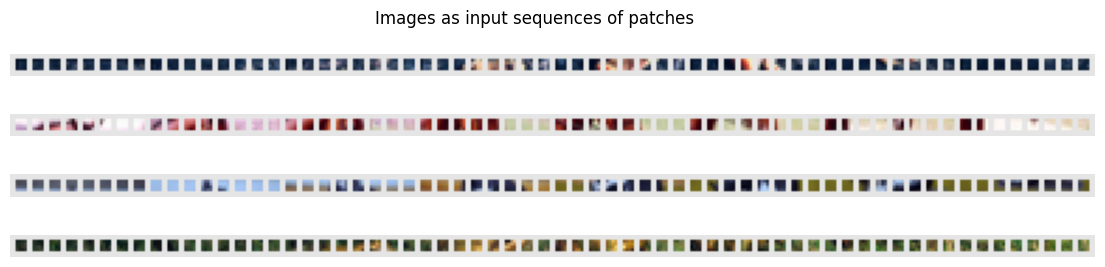

In [6]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

print("Image shape:", CIFAR_images.shape)
print("Patches shape:", img_patches.shape)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

## 2. Attention Block

We can now proceed to construct the Transformer model. Having covered the basics of Multi-Head Attention in the course, your task is to implement the attention block in this section.

<div align="center">
    <img src="https://media.geeksforgeeks.org/wp-content/uploads/20240110170625/Scaled-Dot-Product-and-Multi-Head-Attentions.webp" alt="Transformer block" width="60%" height="60%">
</div>


The scaled dot-product attention mechanism follows this formula:

$$ \text{Attention}(Q, K, V) = \text{softmax}_\text{row} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V$$

Here, the queries \( Q \), keys \( K \), and values \( V \) are obtained by applying linear transformations to the input \( X \):

$$Q = X W_Q^T, \quad K = X W_K^T, \quad V = X W_V^T$$

where $ W_Q, W_K, W_V $ are learned weight matrices.

The scaling factor $ d_k $ is the dimensionality of each attention head, computed as:

$$d_k = \frac{\text{dim}}{\text{num\_heads}}$$

The attention computation is performed in parallel across $\text{num\_heads}$ independent heads, each operating in a $ d_k $-dimensional subspace. The outputs from all heads are then concatenated along the feature dimension. Ensure that your implementation avoids explicit loops over the heads and instead uses efficient tensor operations.


In [7]:
import torch
import torch.nn as nn
#from einops import rearrange

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        """
        Multi-head self-attention layer.

        Args:
            embed_dim (int): Dimensionality of each token.
            num_heads (int, optional): Number of attention heads. Defaults to 8.
        """
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # Dimensionality of each attention head
        self.scale_factor = self.head_dim ** -0.5  # Scaling factor for attention scores

        # TODO: Linear transformations to compute queries (Q), keys (K), and values (V) projecting the input to multi-head dimension
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # TODO: Linear transformation project back the output to original embedding dimension
        self.output_projection = nn.Linear(embed_dim, embed_dim)


    def forward(self, input_tensor):
        """
        Forward pass for multi-head self-attention.

        Args:
            input_tensor (torch.Tensor): Input tensor of shape [batch_size, seq_length, embed_dim].
            attention_mask (torch.Tensor, optional): Mask tensor of shape [batch_size, seq_length, seq_length].
                                                    Used to mask out specific positions in the attention map.
        Returns:
            torch.Tensor: Output tensor of shape [batch_size, seq_length, embed_dim].
        """
        batch_size, seq_length, embed_dim = input_tensor.shape

        # TODO: Compute Q, K, and V matrices and reshape them for multi-head attention
        q = self.q(input_tensor)  # Shape: [batch_size, seq_length, embed_dim]
        k = self.k(input_tensor)
        v = self.v(input_tensor)

        # TODO: Compute scaled dot-product attention scores using Q and K matrices and scale factor
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale_factor

        # TODO: Normalize attention scores using softmax
        attention_weights = nn.functional.softmax(attention_scores, dim=-1)

        # TODO: Compute attention output by multiplying the attention weights with the V matrix
        attention_output = torch.matmul(attention_weights, v)

        # TODO: Concatenate attention heads and project back to original embedding dimension
        output_tensor = attention_output.transpose(1,2).contiguous().view(batch_size, seq_length, embed_dim)

         # Shape: [batch_size, seq_length, embed_dim]

        return output_tensor

## 3. FeedforwardBlock(MLP layer)

In the following cell, implement the feedforward block using two-layer Perceptron:

$$ \text{MLP}(X) = \text{GeLU}(X W_1^T + b_1) W_2^T + b_2 $$

Here, $\text{GeLU}$ denotes the [GeLU activation function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html).
The first linear layer projects x from dimension `dim` to `hidden_dim`, while the second projects it back to `dim`.

In [8]:
class FeedforwardBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()

        # TODO: Define two linear transformations with GELU activation
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.activation = nn.GELU()

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

### Transformer Encoder block

In the next cell, implement a Transformer block combining the MultiheadselfAttention and FeedForward Blocks:

$$ X_a = X + \text{Attention}(\text{LN}(X)) $$
$$ X_b = X_a + \text{MLP}(\text{LN}(X_a)) $$

Here, $\text{LN}$ denotes two LayerNorm layers.

In [9]:
class TransformerBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
        """
        super().__init__()

        # TODO: Initialize the MultiHeadSelfAttention, FeedforwardBlock and LayerNorm layers.
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.feedforward = FeedforwardBlock(embed_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(embed_dim)


    def forward(self, x):
        # TODO: Implement the forward pass in the order of:
        # LayerNorm -> Multi-Head Self-Attention -> Add Residual -> LayerNorm -> Feedforward -> Add Residual
        x = x + self.attention(self.norm1(x))
        x = x + self.feedforward(self.norm1(x))
        return x

## 4. Fitting the pieces together to build Vision Transformer

Now we have all components ready to build our own Vision Transformer.

let's revisit the transformer block:

<div align="center">
  <img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" alt="Transformer block">
</div>

We have already implemented all these components: Image to Patches, Positional Embeddings, Classification Token, Transformer Block, MLP Head for classification etc

1. **Image to Patches**:
The `img_to_patch` function splits an image into smaller patches. For an image of size \(N \times N\), it creates \((N/M)^2\) patches of size \(M \times M\). These patches are then flattened and used as input tokens for the Transformer.

2. **Classification Token**:
A learnable classification token (`cls_token`) is prepended to the sequence of patch embeddings. This token aggregates information from all patches and is used for the final classification.

3. **Positional Embeddings**:
Positional embeddings (`pos_embedding`) are added to the patch embeddings to retain spatial information. These embeddings help the model understand the relative positions of patches.

4. **Transformer Block**:
The `TransformerBlock` consists of:
- **Multi-Head Self-Attention**: Computes attention scores for each token and aggregates information from all tokens.
- **Feedforward Block**: A two-layer MLP with GeLU activation that processes each token independently.
- **Residual Connections and Layer Normalization**: Applied before and after the attention and feedforward blocks to stabilize training.

5. **MLP Head for Classification**:
The `mlp_head` is a simple feedforward neural network used for classification. It consists of a LayerNorm layer followed by a linear layer that maps the final CLS token embedding to the output classes.

With these components in mind, let's implement the full Vision Transformer below:

In [10]:
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches):
        """
        Vision Transformer for image classification.

        Args:
            embed_dim: Size of token embeddings.
            hidden_dim: Hidden layer size in feed-forward networks.
            num_channels: Number of input channels (e.g., 3 for RGB).
            num_heads: Number of attention heads.
            num_layers: Number of transformer layers.
            num_classes: Number of output classes.
            patch_size: Size of each image patch.
            num_patches: Total number of patches in an image.
        """
        super().__init__()

        self.patch_size = patch_size

        # TODO: Define the patch embedding layer using a linear layer.
        self.patch_embedding = nn.Linear(num_channels * patch_size * patch_size, embed_dim)

        # TODO: Define the transformer blocks.
        self.transformers = nn.ModuleList([
            TransformerBlock(embed_dim, hidden_dim, num_heads) for _ in range(num_layers)
        ])

        # TODO: Define the MLP head used for classification using a LayerNorm and linear layer.
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        # Learnable class token & positional embeddings.
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # TODO: Define a dropout layer.
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        """
        Forward pass of Vision Transformer.

        Args:
            x: Input image tensor (batch_size, num_channels, height, width)

        Returns:
            Output logits (batch_size, num_classes)
        """
        B = x.shape[0]

        # TODO: Convert image to patches and apply patch embedding.
        x = img_to_patch(x, self.patch_size)
        x = self.patch_embedding(x)

        # shape: [B, num_patches, embed_dim]

        # Add CLS token.
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)   # shape: [B, num_patches + 1, embed_dim]

        # TODO: Add positional embeddings
        x = x + self.pos_embedding


        # TODO: Apply dropout
        x = self.dropout(x)

        # TODO: Pass the embedded patches through the transformer blocks.
        for transformer in self.transformers:
            x = transformer(x)

        # Extract the CLS token output for classification.
        cls_output = x[:, 0]

        return self.mlp_head(cls_output)

## Model Training and Evaulation

In [11]:
# Initialize the model, loss function, and optimizer

learning_rate = 3e-4
model = VisionTransformer(
    embed_dim=256,
    hidden_dim=512,
    num_channels=3,
    num_heads=8,
    num_layers=10,
    num_classes=10,
    patch_size=4,
    num_patches=64
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [12]:
from tqdm.notebook import tqdm

# Define hyperparameters
num_epochs = 10

train_losses = []
val_losses = []
# Training loop
for epoch in range(num_epochs):

    model.train()
    epoch_train_loss = 0.0
    pbar = tqdm(total=len(train_loader))

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        pbar.update(1)
        pbar.set_description(f'Training loss: {loss.item():.3f}')

    pbar.close()

    epoch_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.5085


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [2/10], Loss: 1.2334


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [3/10], Loss: 1.1260


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [4/10], Loss: 1.0385


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.9603


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.8872


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.8097


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.7360


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.6526


  0%|          | 0/766 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.5726


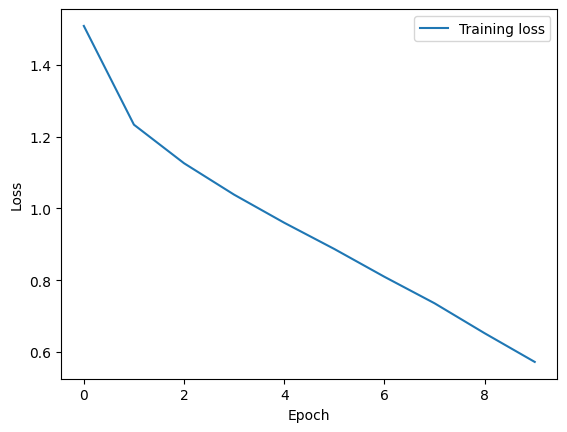

In [13]:
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Validation/Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation/Test Accuracy: {100 * correct / total:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation/Test Accuracy: 61.00%


Now, we can put everything into a PyTorch Lightning Module as usual. We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation.

## Theory (10%)

### Question 1

How does the patch size affects the Vision Transformer model and it's performance? What does patch size 1 implies?

### Ans

Patch size affects the Vision Transformer model in the following ways:
- Smaller patch sizes allow the model to capture more fine-grained details in the input images, which can be beneficial for tasks that require high-resolution information.
- Larger patch sizes reduce the number of tokens in the input sequence, which can help reduce the computational complexity of the model and improve training efficiency.
- Patch size 1 implies that each pixel in the input image is treated as a separate token, resulting in a large number of tokens and potentially high computational costs. This approach may be suitable for tasks that require pixel-level information but may not be practical for large images due to memory constraints.

### Question 2

How does the dataset size affects performance of Transformer? Does it need more data as compared to CNN for the same task?

### Ans

The dataset size can affect the performance of a Transformer model in the following ways:
- Larger datasets can help improve the generalization and performance of Transformer models by providing more diverse and representative examples for training.
- Transformers may require more data compared to CNNs for the same task due to their capacity to capture complex relationships and dependencies in the data. Transformers rely on self-attention mechanisms to model long-range dependencies, which may require more data to learn effectively.
- However, the performance of a Transformer model is not solely determined by the dataset size. Other factors such as model architecture, hyperparameters, and training procedures also play a significant role in determining the model's performance.

### Question 3

Now you have trained a CNN and a transformer model on CIFAR for image classification.
How was the performance of both models?

What differences do you observe between both models in terms of architecture, training time,.. etc. Discuss your observations and provide reasoning about it.

### Ans

???

## References

Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." International Conference on Learning Representations (2021). [link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al. "When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations." arXiv preprint arXiv:2106.01548 (2021). [link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al. "MLP-mixer: An all-MLP Architecture for Vision." arXiv preprint arXiv:2105.01601 (2021). [link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al. "On layer normalization in the transformer architecture." International Conference on Machine Learning. PMLR, 2020. [link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)